In [1]:
# https://nilearn.github.io/auto_examples/plot_single_subject_single_run.html#sphx-glr-auto-examples-plot-single-subject-single-run-py

from nilearn.datasets import fetch_spm_auditory
subject_data = fetch_spm_auditory()


Dataset created in /Users/vaibhavsharma/nilearn_data/spm_auditory

Data absent, downloading...


Downloaded 33366016 of 34212021 bytes (97.5%,    0.3s remaining) ...done. (13 seconds, 0 min)
Extracting data from /Users/vaibhavsharma/nilearn_data/spm_auditory/sub001/MoAEpilot.zip..... done.


In [2]:
subject_data.func

['/Users/vaibhavsharma/nilearn_data/spm_auditory/sub001/fM00223/fM00223_004.img',
 '/Users/vaibhavsharma/nilearn_data/spm_auditory/sub001/fM00223/fM00223_005.img',
 '/Users/vaibhavsharma/nilearn_data/spm_auditory/sub001/fM00223/fM00223_006.img',
 '/Users/vaibhavsharma/nilearn_data/spm_auditory/sub001/fM00223/fM00223_007.img',
 '/Users/vaibhavsharma/nilearn_data/spm_auditory/sub001/fM00223/fM00223_008.img',
 '/Users/vaibhavsharma/nilearn_data/spm_auditory/sub001/fM00223/fM00223_009.img',
 '/Users/vaibhavsharma/nilearn_data/spm_auditory/sub001/fM00223/fM00223_010.img',
 '/Users/vaibhavsharma/nilearn_data/spm_auditory/sub001/fM00223/fM00223_011.img',
 '/Users/vaibhavsharma/nilearn_data/spm_auditory/sub001/fM00223/fM00223_012.img',
 '/Users/vaibhavsharma/nilearn_data/spm_auditory/sub001/fM00223/fM00223_013.img',
 '/Users/vaibhavsharma/nilearn_data/spm_auditory/sub001/fM00223/fM00223_014.img',
 '/Users/vaibhavsharma/nilearn_data/spm_auditory/sub001/fM00223/fM00223_015.img',
 '/Users/vaibhav

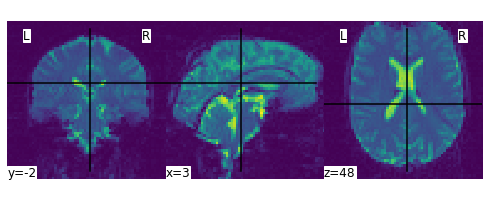

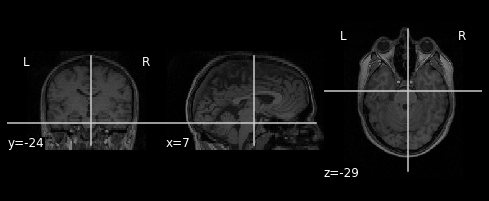

In [7]:
from nilearn.plotting import plot_stat_map, plot_anat, plot_img
plot_img(subject_data.func[0])
plot_anat(subject_data.anat)



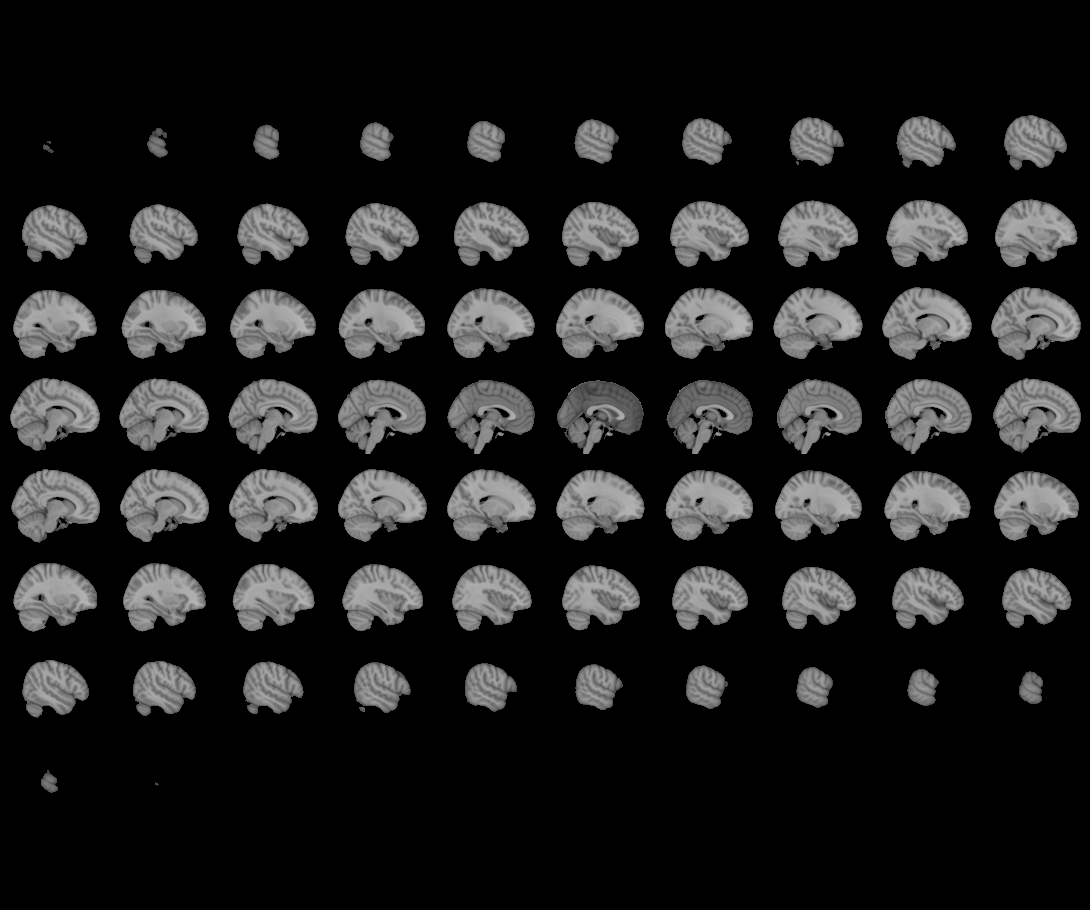
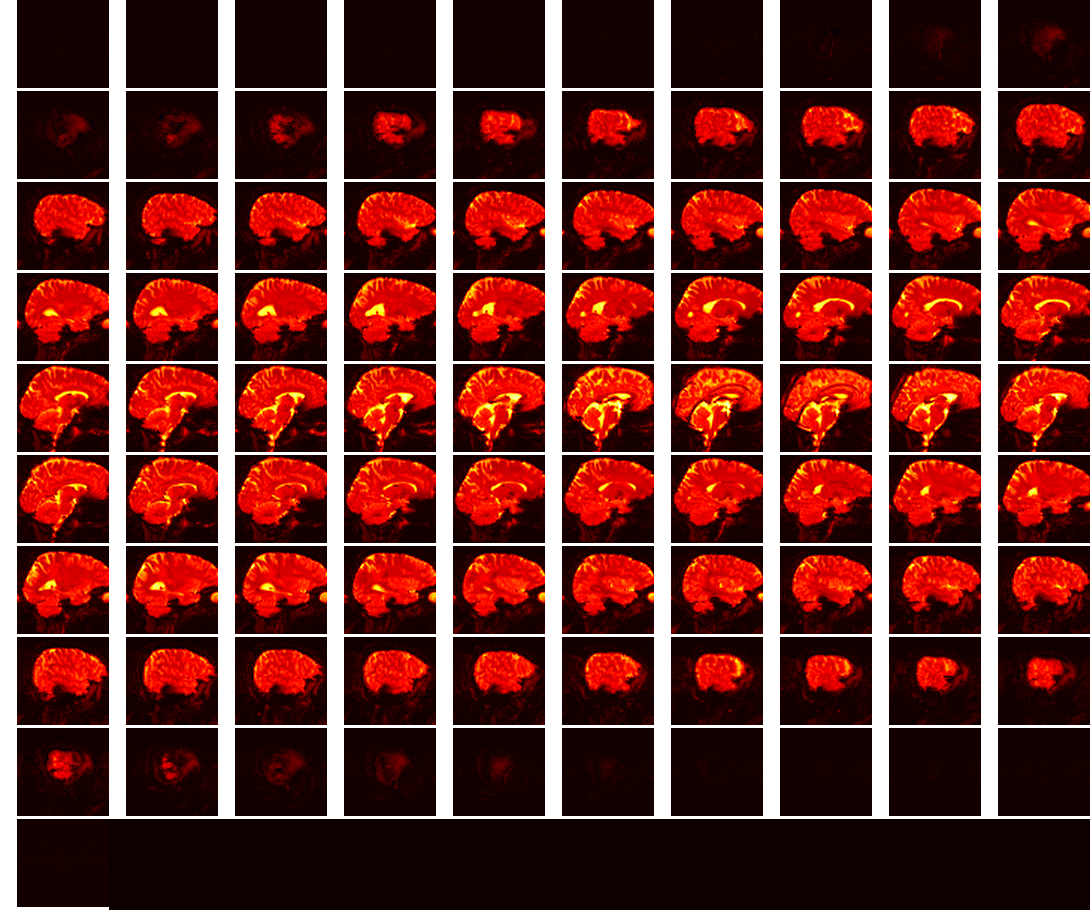

In [8]:
from nilearn import plotting
from nilearn.image import concat_imgs, mean_img
plotting.view_img(mean_img(subject_data.func), threshold=None)



In [9]:
fmri_img = concat_imgs(subject_data.func)
mean_img = mean_img(fmri_img)

In [11]:
# We must now provide a description of the experiment, that is, 
# define the timing of the auditory stimulation and rest periods. 
# This is typically provided in an events.tsv file. The path of this file is provided in the dataset.
import pandas as pd
events = pd.read_table(subject_data['events'])
events

,onset,duration,trial_type
0,0.0,42.0,rest
1,42.0,42.0,active
2,84.0,42.0,rest
3,126.0,42.0,active
4,168.0,42.0,rest
5,210.0,42.0,active
6,252.0,42.0,rest
7,294.0,42.0,active
8,336.0,42.0,rest
9,378.0,42.0,active


In [13]:
#It is now time to create and estimate a FirstLevelModel object, 
# that will generate the design matrix using the information provided by the events object.
from nilearn.glm.first_level import FirstLevelModel

In [14]:
'''
Parameters of the first-level model

t_r=7(s) is the time of repetition of acquisitions
noise_model=’ar1’ specifies the noise covariance model: a lag-1 dependence
standardize=False means that we do not want to rescale the time series to mean 0, variance 1
hrf_model=’spm’ means that we rely on the SPM “canonical hrf” model (without time or dispersion derivatives)
drift_model=’cosine’ means that we model the signal drifts as slow oscillating time functions
high_pass=0.01(Hz) defines the cutoff frequency (inverse of the time period).

'''
fmri_glm = FirstLevelModel(t_r=7,
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm',
                           drift_model='cosine',
                           high_pass=.01)

In [15]:
fmri_glm = fmri_glm.fit(fmri_img, events)

In [16]:
# One can inspect the design matrix (rows represent time, and columns contain the predictors).
design_matrix = fmri_glm.design_matrices_[0]

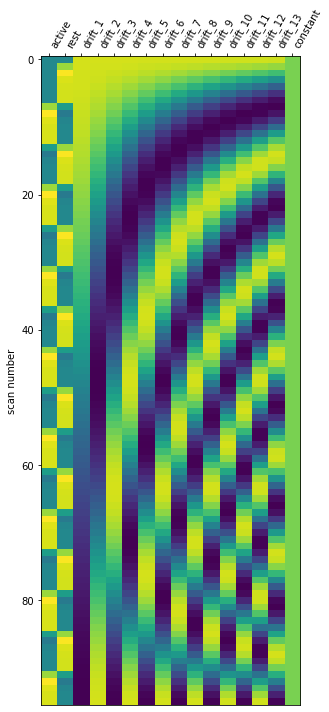

In [17]:
from nilearn.plotting import plot_design_matrix
plot_design_matrix(design_matrix)
import matplotlib.pyplot as plt
plt.show()

In [19]:
# Save the design matrix image to disk first create a directory where you want to write the images
import os
outdir = 'results'
if not os.path.exists(outdir):
    os.mkdir(outdir)

from os.path import join
plot_design_matrix(
    design_matrix, output_file=join(outdir, 'design_matrix.png'))

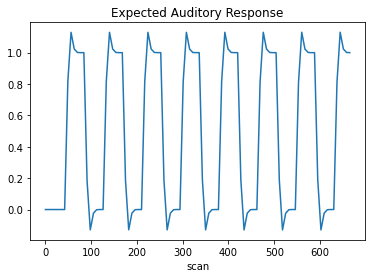

In [20]:
# The first column contains the expected response profile of regions which are sensitive to the auditory stimulation. 
# Let’s plot this first column
plt.plot(design_matrix['active'])
plt.xlabel('scan')
plt.title('Expected Auditory Response')
plt.show()

In [21]:
# To access the estimated coefficients (Betas of the GLM model), we created contrast with a single ‘1’ in each of the columns: 
# The role of the contrast is to select some columns of the model –and potentially weight them– to study the associated statistics.
# So in a nutshell, a contrast is a weighted combination of the estimated effects. 
# Here we can define canonical contrasts that just consider the two effects in isolation —let’s call them “conditions”— then a contrast that makes the difference between these conditions.
from numpy import array
conditions = {
    'active': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                     0.]),
    'rest':   array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                     0.]),
}


In [23]:
active_minus_rest = conditions['active'] - conditions['rest']
active_minus_rest

array([ 1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.])

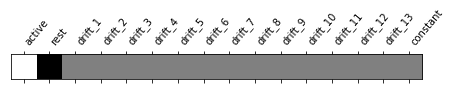

In [24]:
from nilearn.plotting import plot_contrast_matrix
plot_contrast_matrix(active_minus_rest, design_matrix=design_matrix)